# DM-45279: add extra-focal to donut_viz  PlotDonutTask()





* cloned donut_viz to `/home/s/scichris/link_to_scichris/WORK/donut_viz`
* created a ticket branch  tickets/DM-45279

* w2024_16
* development code below from https://github.com/lsst-ts/donut_viz/blob/main/python/lsst/donut/viz/plotAOSTask.py#L236



Take a bunch of donuts from eg. a recent simulation for LsstComCam:

In [1]:
import os
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
import sys
import lsst.utils.tests
from lsst.daf import butler as dafButler
from lsst.ts.wep.task.cutOutDonutsCwfsTask import (
    CutOutDonutsCwfsTask,
    CutOutDonutsCwfsTaskConfig,
)
from lsst.ts.wep.utils import (
    DefocalType,
    getModulePath,
    runProgram,
    writeCleanUpRepoCmd,
    writePipetaskCmd,
)

raws:

In [4]:
butlerRootPath ='/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = butler.registry.queryDatasets(datasetType='raw',collections=['LSSTComCam/raw/all']).expanded()
refs = []
for ref  in datasetRefs:
   # print(ref)
    refs.append(ref)
 

results of running WEP as a pipetask (including postISR)

In [7]:
collection='runWEP_940-942_d_2024_05_06_mag_sn'
datasetRefs = butler.registry.queryDatasets(datasetType='donutStampsExtra',collections=[collection]).expanded()
pipeRefs = []
for ref  in datasetRefs:
    print(ref)
    pipeRefs.append(ref)


donutStampsExtra@{instrument: 'LSSTComCam', detector: 1, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=runWEP_940-942_d_2024_05_06_mag_sn/20240508T012620Z id=3706a452-80c2-4c94-bbe6-f054c7852b88)
donutStampsExtra@{instrument: 'LSSTComCam', detector: 5, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=runWEP_940-942_d_2024_05_06_mag_sn/20240508T012620Z id=79c8c61f-7811-4b31-9ec6-43c9907cdec7)
donutStampsExtra@{instrument: 'LSSTComCam', detector: 3, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=runWEP_940-942_d_2024_05_06_mag_sn/20240508T012620Z id=0f35ae0a-3bfc-4aaf-8e7e-878c05bf134d)
donutStampsExtra@{instrument: 'LSSTComCam', detector: 4, visit: 5025082000942, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=runWEP_940-942_d_2024_05_06_mag_sn/20240508T012620Z id=262574e5-2688-4037-af9d-c5fc7b208434)
donutStampsExtra@{instrument: 'LSSTComCam', detector: 8, visit: 5025082000942, band:

In [10]:
pipeRefs[0].dataId.visit

visit.RecordClass(instrument='LSSTComCam', id=5025082000942, physical_filter='g_01', name='IM_P_20250820_000942', day_obs=20250820, seq_num=942, exposure_time=15.0, target_name='UNKNOWN', observation_reason='survey', science_program='68661', azimuth=None, zenith_angle=None, region=ConvexPolygon([UnitVector3d(0.059721775597359396, -0.13090458486377476, -0.9895945125055724), UnitVector3d(0.06376964052795439, -0.12909745299017475, -0.9895793452666568), UnitVector3d(0.06882471780083474, -0.1404355415081154, -0.9876947994704426), UnitVector3d(0.06508420753249194, -0.1421058038907733, -0.9877094645848163), UnitVector3d(0.057292473539824536, -0.14557585567565104, -0.9876868140863229), UnitVector3d(0.05399495196070508, -0.13818011312631134, -0.9889341745026111), UnitVector3d(0.05223739634545768, -0.13423776695632936, -0.9895713599057047)]), timespan=Timespan(begin=astropy.time.Time('2025-08-20 05:56:31.670602', scale='tai', format='iso'), end=astropy.time.Time('2025-08-20 05:56:46.671000', scale='tai', format='iso')))

Read the donut stamps extra , intra, for the first detector: 

In [15]:

donutStampsIntra  = butler.get('donutStampsIntra', dataId = pipeRefs[0].dataId, collections=[collection])
donutStampsExtra  = butler.get('donutStampsExtra', dataId=pipeRefs[0].dataId, collections=[collection])


In [40]:
len(donutStampsExtra)

55

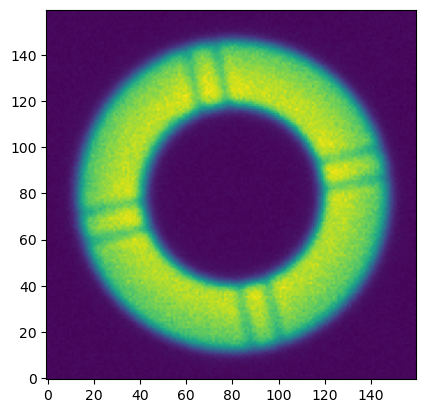

In [41]:
fig,ax = plt.subplots(1,1)
ax.imshow(donutStampsIntra[0].stamp_im.image.array, origin='lower')

This is the brightest intra-focal donut- a single brightest donut is what I'd expect to see.

In [23]:
dataId = {'exposure': pipeRefs[0].dataId['visit'], 
          'detector':pipeRefs[0].dataId['detector'],
          'instrument':pipeRefs[0].dataId['instrument']
         }
exposure = butler.get('postISRCCD', dataId= dataId, collections=[collection])
info = exposure.getInfo()
visitInfo = info.getVisitInfo() 
focusZ = visitInfo.focusZ

In [25]:
visitInfo.boresightParAngle

Angle(57.539158073891969, degrees)

To use the `donut_viz` functions here I append the path:

In [34]:
sys.path.append('/home/s/scichris/link_to_scichris/WORK/donut_viz/python/lsst/donut/viz')

In [36]:
from utilities import (
    rose, add_rotated_axis, get_instrument_channel_name,
    get_day_obs_seq_num_from_visitid
)

Try running the code as-is on the  intra-focal donuts.. 

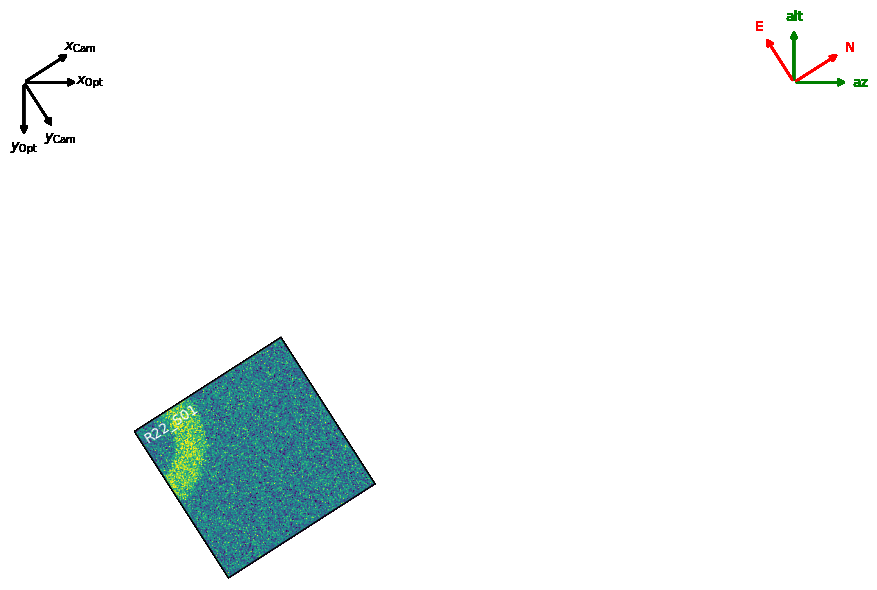

In [38]:
%matplotlib inline

fig = plt.figure(figsize=(11, 8.5))
aspect = fig.get_size_inches()[0] / fig.get_size_inches()[1]

# LSST detector layout
q = visitInfo.boresightParAngle.asRadians()
rotAngle = visitInfo.boresightRotAngle.asRadians()
rtp = q - rotAngle - np.pi/2
match inst:=visitInfo.getInstrumentLabel():
    case 'LSSTCam' | 'LSSTCamSim':
        nacross = 15
        fp_size = 0.55  # 55% of horizontal space
    case 'LSSTComCam' | 'LSSTComCamSim':
        nacross = 3
        fp_size = 0.50  # 50% of horizontal space
    case _:
        raise ValueError(f"Unknown instrument {inst}")
det_size = fp_size/nacross
fp_center = 0.5, 0.475

for donut in donutStampsIntra:
        det_name = donut.detector_name
        # if 'R30' in det_name:
        #     continue
        # if 'S00' in det_name:
        #     continue
        # if 'S01' in det_name:
        #     continue
        i = 3*int(det_name[1]) + int(det_name[5])
        j = 3*int(det_name[2]) + int(det_name[6])
        x = i-7
        y = 7-j
        xp = np.cos(rtp)*x + np.sin(rtp)*y
        yp = -np.sin(rtp)*x + np.cos(rtp)*y
        ax, aux_ax = add_rotated_axis(
            fig,
            (xp*det_size + fp_center[0], yp*det_size*aspect + fp_center[1]),
            (det_size*1.25, det_size*1.25),
            -np.rad2deg(rtp)
        )
        arr = donut.stamp_im.image.array
        vmin, vmax = np.quantile(arr, (0.01, 0.99))
        aux_ax.imshow(
            donut.stamp_im.image.array.T,
            vmin=vmin, vmax=vmax,
            extent=[0, det_size*1.25, 0, det_size*1.25],
            origin='upper'  # +y is down
        )
        xlim = aux_ax.get_xlim()
        ylim = aux_ax.get_ylim()
        aux_ax.text(
            xlim[0] + 0.03 * (xlim[1] - xlim[0]),
            ylim[1] - 0.03 * (ylim[1] - ylim[0]),
            det_name,
            color='w',
            rotation=-np.rad2deg(rtp),
            rotation_mode='anchor',
            ha='left',
            va='top'
            )

        vecs_xy = {
            '$x_\mathrm{Opt}$':(1,0),
            '$y_\mathrm{Opt}$':(0,-1),
            '$x_\mathrm{Cam}$':(np.cos(rtp), -np.sin(rtp)),
            '$y_\mathrm{Cam}$':(-np.sin(rtp), -np.cos(rtp)),
        }
        rose(fig, vecs_xy, p0=(0.15, 0.8))

        vecs_NE = {
            'az':(1,0),
            'alt':(0,+1),
            'N':(np.sin(q), np.cos(q)),
            'E':(np.sin(q-np.pi/2), np.cos(q-np.pi/2))
        }
        rose(fig, vecs_NE, p0=(0.85, 0.8))

So this looks like the last intra-focal donut: 

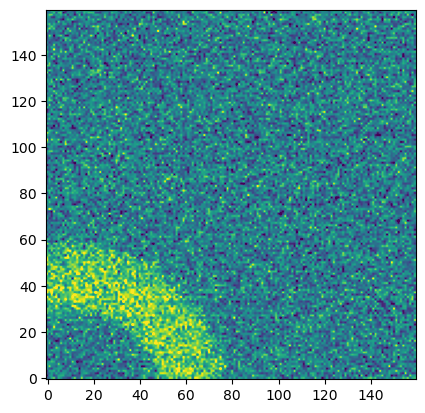

In [45]:
fig,ax = plt.subplots(1,1)
arr = donutStampsIntra[-1].stamp_im.image.array
vmin, vmax = np.quantile(arr, (0.01, 0.99))
ax.imshow(arr, vmin=vmin, vmax=vmax, origin='lower')

**Source code** for development above:

    def runQuantum(
            self,
            butlerQC: pipeBase.QuantumContext,
            inputRefs: pipeBase.InputQuantizedConnection,
            outputRefs: pipeBase.OutputQuantizedConnection
        ) -> None:
            visit = inputRefs.donutStampsIntraVisit.dataId['visit']
            for visitInfoRef in inputRefs.visitInfos:
                if visitInfoRef.dataId['exposure'] == visit:
                    visitInfo = butlerQC.get(visitInfoRef)
                    break
            else:
                raise ValueError(f"Expected to find a visitInfo with exposure {visit}")
    
            donutStampsIntra = butlerQC.get(inputRefs.donutStampsIntraVisit)
            donutStampsExtra = butlerQC.get(inputRefs.donutStampsExtraVisit)
    
            fig = plt.figure(figsize=(11, 8.5))
            aspect = fig.get_size_inches()[0] / fig.get_size_inches()[1]
    
            # LSST detector layout
            q = visitInfo.boresightParAngle.asRadians()
            rotAngle = visitInfo.boresightRotAngle.asRadians()
            rtp = q - rotAngle - np.pi/2
            match inst:=visitInfo.getInstrumentLabel():
                case 'LSSTCam' | 'LSSTCamSim':
                    nacross = 15
                    fp_size = 0.55  # 55% of horizontal space
                case 'LSSTComCam' | 'LSSTComCamSim':
                    nacross = 3
                    fp_size = 0.50  # 50% of horizontal space
                case _:
                    raise ValueError(f"Unknown instrument {inst}")
            det_size = fp_size/nacross
            fp_center = 0.5, 0.475
    
            for donut in donutStampsIntra:
                det_name = donut.detector_name
                # if 'R30' in det_name:
                #     continue
                # if 'S00' in det_name:
                #     continue
                # if 'S01' in det_name:
                #     continue
                i = 3*int(det_name[1]) + int(det_name[5])
                j = 3*int(det_name[2]) + int(det_name[6])
                x = i-7
                y = 7-j
                xp = np.cos(rtp)*x + np.sin(rtp)*y
                yp = -np.sin(rtp)*x + np.cos(rtp)*y
                ax, aux_ax = add_rotated_axis(
                    fig,
                    (xp*det_size + fp_center[0], yp*det_size*aspect + fp_center[1]),
                    (det_size*1.25, det_size*1.25),
                    -np.rad2deg(rtp)
                )
                arr = donut.stamp_im.image.array
                vmin, vmax = np.quantile(arr, (0.01, 0.99))
                aux_ax.imshow(
                    donut.stamp_im.image.array.T,
                    vmin=vmin, vmax=vmax,
                    extent=[0, det_size*1.25, 0, det_size*1.25],
                    origin='upper'  # +y is down
                )
                xlim = aux_ax.get_xlim()
                ylim = aux_ax.get_ylim()
                aux_ax.text(
                    xlim[0] + 0.03 * (xlim[1] - xlim[0]),
                    ylim[1] - 0.03 * (ylim[1] - ylim[0]),
                    det_name,
                    color='w',
                    rotation=-np.rad2deg(rtp),
                    rotation_mode='anchor',
                    ha='left',
                    va='top'
                )
    
            vecs_xy = {
                '$x_\mathrm{Opt}$':(1,0),
                '$y_\mathrm{Opt}$':(0,-1),
                '$x_\mathrm{Cam}$':(np.cos(rtp), -np.sin(rtp)),
                '$y_\mathrm{Cam}$':(-np.sin(rtp), -np.cos(rtp)),
            }
            rose(fig, vecs_xy, p0=(0.15, 0.8))
    
            vecs_NE = {
                'az':(1,0),
                'alt':(0,+1),
                'N':(np.sin(q), np.cos(q)),
                'E':(np.sin(q-np.pi/2), np.cos(q-np.pi/2))
            }
            rose(fig, vecs_NE, p0=(0.85, 0.8))
    
            butlerQC.put(fig, outputRefs.donutPlot)
    
            if self.config.doRubinTVUpload:
                instrument = inputRefs.donutStampsIntraVisit.dataId['instrument']
                visit = inputRefs.donutStampsIntraVisit.dataId['visit']
                day_obs, seq_num = get_day_obs_seq_num_from_visitid(visit)
                with tempfile.TemporaryDirectory() as tmpdir:
                    donut_gallery_fn = Path(tmpdir) / 'fp_donut_gallery.png'
                    fig.savefig(donut_gallery_fn)
    
                    self.uploader.uploadPerSeqNumPlot(
                        instrument=get_instrument_channel_name(instrument),
                        plotName='fp_donut_gallery',
                        dayObs=day_obs,
                        seqNum=seq_num,
                        filename=donut_gallery_fn
                )